### 1. Importación de las Libreria a utilizar, declaracion de variables y configuraciones para optimizacion de los procesos

In [ ]:
!pip install -r requeriments.txt

In [95]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from torchvision import datasets, transforms

In [96]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)
torch.set_float32_matmul_precision('medium')
model_cnn = None
learning_rates  = [0.01]

### 2. Parámetros y Preparación de los Datos a utilizar.

Se descarga el dataset de MNIST y transformacion del mismo. Creacion de de los dataloader de Train y Validation.

In [97]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = './', train_batch_size: int = 256, val_batch_size: int = 256):
        super().__init__()
        self.data_dir = data_dir
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size

    def prepare_data(self):
        # Descarga MNIST si no está disponible en data_dir
        datasets.MNIST(self.data_dir, train=True, download=True)
        datasets.MNIST(self.data_dir, train=False, download=True)
        

    def setup(self, stage=None):
        # Definir transformaciones para entrenamiento y validación
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    
        # Crear los datasets de entrenamiento y validación
        self.mnist_train = datasets.MNIST(self.data_dir, train=True, transform=transform)
        self.mnist_val = datasets.MNIST(self.data_dir, train=False, transform=transform)
        
        # Suponiendo que 'dataset' es un objeto que devuelve (imagen, etiqueta) para cada muestra:
        sample, _ = self.mnist_train[0]
        self.input_shape = sample.shape  # Esto devolverá torch.Size([1, 28, 28]) en MNIST o torch.Size([3, 32, 32]) en CIFAR-10
        print("Input shape:", self.input_shape)
        

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train,
            batch_size=self.train_batch_size,
            shuffle=True,
            num_workers=5,
            persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.mnist_val,
            batch_size=self.val_batch_size,
            shuffle=False,
            num_workers=5,
            persistent_workers=True
        )


Vista de una muestra para la parte del Entrenamiento

Input shape: torch.Size([1, 28, 28])


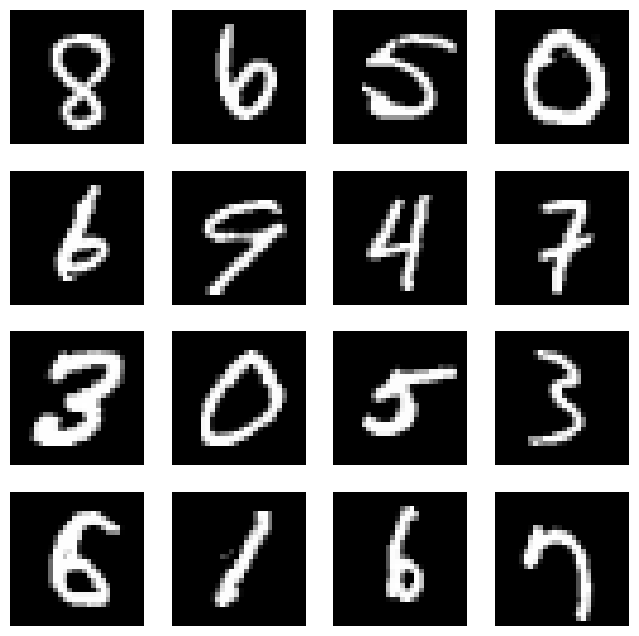

In [98]:
#region Instanciar el DataModule para MNIST
mnist_dm = MNISTDataModule(data_dir='./', train_batch_size=16, val_batch_size=16)
mnist_dm.prepare_data()  # Descarga los datos si no están disponibles
mnist_dm.setup()         # Configura los datasets

# Obtener el DataLoader de entrenamiento
train_loader = mnist_dm.train_dataloader()



# Extraer un batch (de 16 imágenes)
batch_train = next(iter(train_loader))
images, labels = batch_train  # images: tensor de forma (16, 1, 28, 28)

# Visualizar las 16 imágenes
plt.figure(figsize=(8, 8))
#Print("Visualizando las imagenes de Entrenamiento")
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Convertir cada imagen a numpy y eliminar el canal extra
    img = images[i].squeeze().numpy()
    # Como MNIST es en escala de grises, usamos cmap="gray"
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()
#endregion

Visualizacion de una muestra de la parte de Validacion

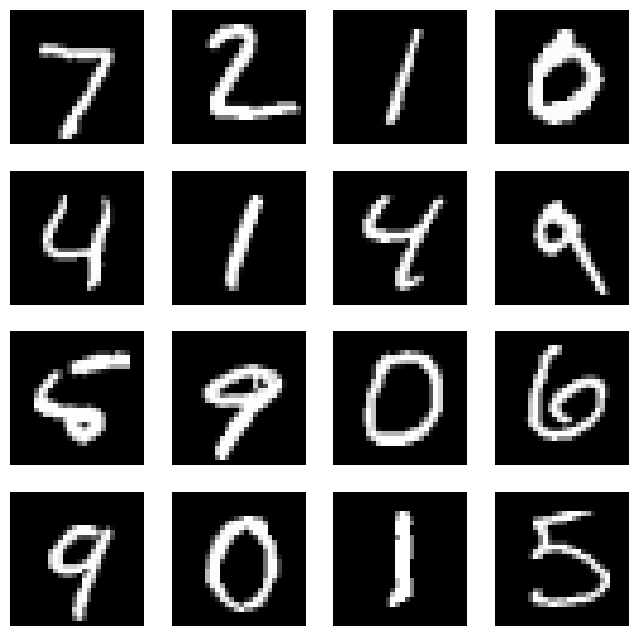

In [99]:
#region bloque visualizacion de imagenes de validacion
val_loader = mnist_dm.val_dataloader()
batch_val = next(iter(val_loader))
images, labels = batch_val  # images: tensor de forma (16, 1, 28, 28)


# Visualizar las 16 imágenes
plt.figure(figsize=(8, 8))
#Print("Visualizando las imagenes de Validacion")
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Convertir cada imagen a numpy y eliminar el canal extra
    img = images[i].squeeze().numpy()
    # Como MNIST es en escala de grises, usamos cmap="gray"
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()
#endregion

### 3. Definición del Encoder con capa Convolucional

Se crea un Encoder con tres capas convolucionales las cuales se normalizan y activan con ReLU y filtros de 32, 64 y 128. Adicional se creaun funcion que permite calcular el size y el shape del flattened (aplanamiento), esta funcion tiene la intencion de evitar inconvenientes al momento de realizar algun tipo de cambio en la estructura de las clases de Encoder o Decoder.

In [100]:
# Funcion para calcular de manera automatica el numero total de elementos tras aplanar la salida y la forma de salida sin la dimension del batch.
# Luego de presentar multiple inconvenientes al pasar de capas lineales a convolucionales, decidi implementar esta funcion para evitar errores futuros a incluir 
# mas capas o modificar su estructura.
def get_flattened_size_and_shape(conv_module, input_shape):
    """
    Pasa un dummy input de tamaño (1, *input_shape) a través del módulo conv_module
    y devuelve:
      - flatten_dim: número total de elementos tras aplanar la salida
      - flatten_shape: la forma de salida sin la dimensión de batch
    """
    dummy_input = torch.zeros(1, *input_shape)
    with torch.no_grad():
        output = conv_module(dummy_input)
    flatten_shape = output.shape[1:]  # Ej. (256, 4, 4)
    flatten_dim = output.view(1, -1).size(1)
    return flatten_dim, flatten_shape


# Encoder con 3 capas convolucionales y un modulo secuencial para las mismas.
class CVAEEncoderConv(nn.Module):
    def __init__(self, label_dim=10, latent_dim=5, input_shape=(1, 28, 28)):    
        super(CVAEEncoderConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) 
        
        
        # Módulo secuencial para las capas convolucionales
        self.conv = nn.Sequential(
            self.conv1,
            nn.BatchNorm2d(32),  
            nn.ReLU(),
            self.conv2,
            nn.BatchNorm2d(64),  
            nn.ReLU(),
            self.conv3,
        )

        # Calculo automáticamente la dimensión y la forma aplanada. Esto debido a que ha sido uno de los mas grandes problemas en la implementación de la red que he presentado, 
        # con esto busco evitar que sin importar la modificacion que realizo tanto en el Encoder como en el Decoder, no tenga que modificar la dimensión aplanada. 
        self.flatten_dim, self.flatten_shape = get_flattened_size_and_shape(self.conv, input_shape)
        print("Dimensión aplanada:", self.flatten_dim)
        print("Forma aplanada:", self.flatten_shape)

        self.fc_mu = nn.Linear(self.flatten_dim + label_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim + label_dim, latent_dim)
        
    def forward(self, x, y):
        h = self.conv(x)
        #print("Salida de conv:", h.shape)
        h = h.view(h.size(0), -1)
        #print("Salida aplanada:", h.shape)
        if y.dim() == 1:
            y = F.one_hot(y, num_classes=10).float()
        h = torch.cat([h, y], dim=1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


### 4. Definición del Decoder con capas Convolucionales

Esta clase que posee tres capas  y utiliza ConvTranspose2d posee los filtro de manera inversa iniciando con la salida del ultimo filtro del Encoder o sea 128, 64 y 32 para finalmente salir con 1. Aqui se utiliza de funcion creada en el Encoder para generar el flatten requerido en el proceso y que debe de coincidir con el Encoder.

In [101]:
class CVAEDecoderConv(nn.Module):
    def __init__(self, label_dim=10, latent_dim=5, flatten_dim=2048, flatten_shape=(128, 4, 4)):
        super(CVAEDecoderConv, self).__init__()
        self.label_dim = label_dim
        self.target_shape = flatten_shape  # (256, 4, 4)
        # Capa FC para generar el "mapa" inicial, utilizando flatten_dim = 4096
        self.fc = nn.Linear(latent_dim + label_dim, flatten_dim)
        # Capas de transposed convolutions con parámetros ajustados:
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        
    def forward(self, z, y):
        if y.dim() == 1:
            y = F.one_hot(y, num_classes=self.label_dim).float()
        zy = torch.cat([z, y], dim=1)  # (batch, latent_dim + label_dim)
        h = F.relu(self.fc(zy))         # (batch, flatten_dim) = (batch, 4096)
        h = h.view(-1, *self.target_shape)  # Reshape a (batch, 256, 4, 4)
        h = F.relu(self.bn1(self.deconv1(h)))   # Aplicamos deconv1, luego BatchNorm y ReLU
        h = F.relu(self.bn2(self.deconv2(h)))   # Aplicamos deconv2, luego BatchNorm y ReLU
        x_recon = torch.sigmoid(self.deconv3(h))  # (batch, 1, 28, 28)
        return x_recon


### 5. Definición del Modelo CVAE y Función de Pérdidas para las Convolucionales




In [102]:
# Definición del LightningModule que integra el CVAE para la Convolucionales
class ConvCVAE(pl.LightningModule):
    def __init__(self, label_dim=10, latent_dim=10, input_shape=(1,28,28), lr=5e-4):
        super(ConvCVAE, self).__init__()
        self.save_hyperparameters()
        
        self.encoder = CVAEEncoderConv(label_dim, latent_dim, input_shape = input_shape)
        self.decoder = CVAEDecoderConv(label_dim, latent_dim, flatten_dim=self.encoder.flatten_dim, flatten_shape=self.encoder.flatten_shape)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, y)
        return x_recon, mu, logvar
    
    def loss_function(self, x, x_recon, mu, logvar):
        # x_recon: (batch, 1, 28, 28)
        # x: (batch, 1, 28, 28)
        # BCE
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.size(0)
        # KL
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        total_loss = recon_loss + kl_loss
        return total_loss, recon_loss, kl_loss
    
    def training_step(self, batch, batch_idx):
        x, y = batch  # x: (batch, 1, 28, 28), y: (batch, 10)
        x_recon, mu, logvar = self(x, y)
        loss, recon_loss, kl_loss = self.loss_function(x, x_recon, mu, logvar)
        #print(f'Valores importantes: {loss}, {recon_loss}, {kl_loss}, {self.hparams.lr}')
        self.log("train_loss", loss, prog_bar=True)
        if not hasattr(self, 'losses'):
            self.losses = []
        self.losses.append(loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_recon, mu, logvar = self(x, y)
        loss, _, _ = self.loss_function(x, x_recon, mu, logvar)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def on_train_epoch_end(self):
        #Para promediar la perdida de entrenamiento y mostrarla
        if hasattr(self, 'losses') and len(self.losses) > 0:
            avg_loss = torch.stack(self.losses).mean()
            #print(f'Perdida por epoca: {avg_loss:.4f}')

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)



6. Entrenamiento del Modelo

Metodo para imprimir imagenes por LR

In [103]:
#region Generar imágenes con el modelo entrenado
def generate_images(model, num_samples_per_label=10, device="cuda"):
    model.to(device)   # Mover el modelo al dispositivo especificado
    model.eval()       # Establecer el modelo en modo evaluación
    all_generated = []
    with torch.no_grad():
        for label in range(10):
            # Crear un tensor de etiquetas one-hot para el dígito actual en el dispositivo correcto
            y = torch.zeros(num_samples_per_label, model.hparams.label_dim, device=device)
            y[:, label] = 1.0
            # Generar vectores latentes aleatorios en el dispositivo
            z = torch.randn(num_samples_per_label, model.hparams.latent_dim, device=device)
            # Generar imágenes con el decoder
            generated = model.decoder(z, y)
            all_generated.append(generated.cpu())  # Llevar a CPU para visualización si es necesario
    return all_generated

#endregion

## Metodo para entrenar y generar imagen por Learning Rate

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Entrenando con el Learning Rate: 0.01
Dimensión aplanada: 2048
Forma aplanada: torch.Size([128, 4, 4])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | CVAEEncoderConv | 113 K  | train
1 | decoder | CVAEDecoderConv | 125 K  | train
----------------------------------------------------
238 K     Trainable params
0         Non-trainable params
238 K     Total params
0.956     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Input shape: torch.Size([1, 28, 28])


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.


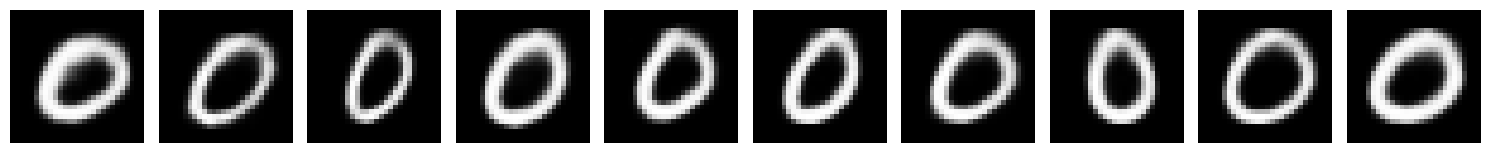

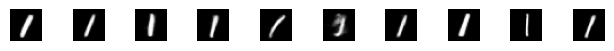

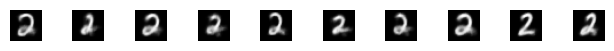

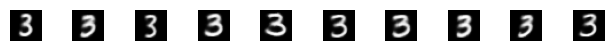

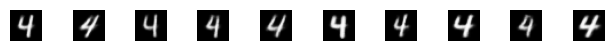

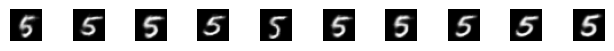

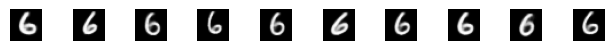

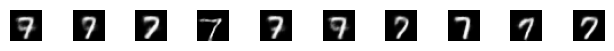

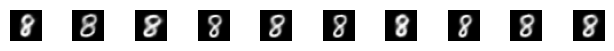

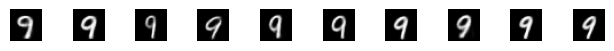

In [104]:
def train_model(learning_rates):
    models_trained = []
    for lr in learning_rates:
        print(f'Entrenando con el Learning Rate: {lr}')
        model = ConvCVAE(label_dim=10, latent_dim=5, input_shape=mnist_dm.input_shape, lr=lr)
        trainer = Trainer(max_epochs=75, accelerator='gpu')
        trainer.fit(model, datamodule=mnist_dm)
        
        generated_images_lr = generate_images(model, num_samples_per_label=10, device="cuda")
        plt.figure(figsize=(15, 15))
        for label in range(10):
            for j in range(10):
                plt.subplot(10, 10, label * 10 + j + 1)
                plt.imshow(generated_images_lr[label][j].squeeze(), cmap="gray")
                plt.axis("off")
            plt.tight_layout()
            plt.show()
        models_trained.append(model)
    return models_trained

# Llamada a la función, por ejemplo, para el primer learning rate:
trained_models = train_model(learning_rates)
model_cnn = trained_models[0]  # Si deseas usar el modelo entrenado con el primer learning rate


### 7. Generación de Imágenes Condicionadas

Adicional se agrega un metodo que al que se le pasan los 10 digitos para ver como lo genera.

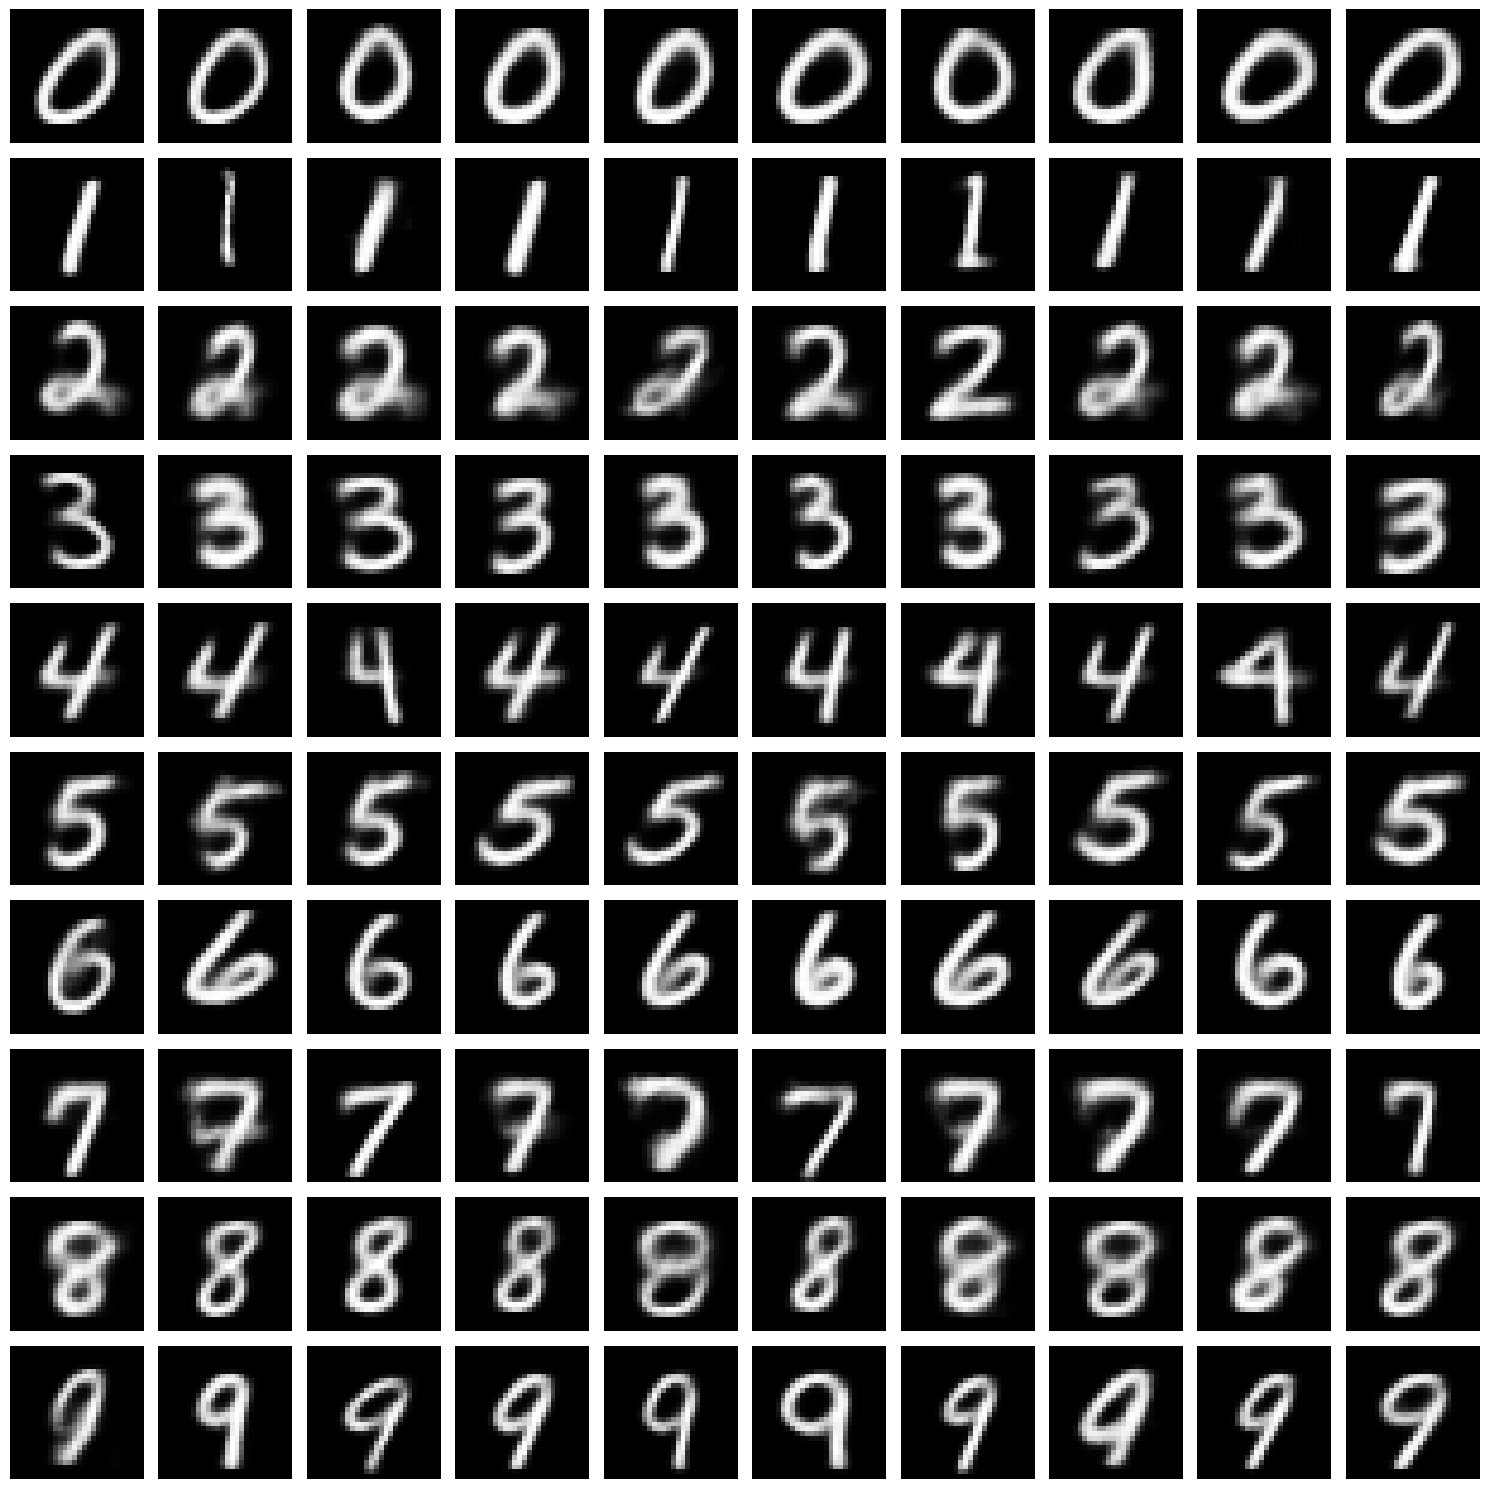

In [105]:
#region Generar imágenes con el modelo entrenado
def generate_images(model, num_samples_per_label=10, device="cuda"):
    model.to(device)   # Mover el modelo al dispositivo especificado
    model.eval()       # Establecer el modelo en modo evaluación
    all_generated = []
    with torch.no_grad():
        for label in range(10):
            # Crear un tensor de etiquetas one-hot para el dígito actual en el dispositivo correcto
            y = torch.zeros(num_samples_per_label, model.hparams.label_dim, device=device)
            y[:, label] = 1.0
            # Generar vectores latentes aleatorios en el dispositivo
            z = torch.randn(num_samples_per_label, model.hparams.latent_dim, device=device)
            # Generar imágenes con el decoder
            generated = model.decoder(z, y)
            all_generated.append(generated.cpu())  # Llevar a CPU para visualización si es necesario
    return all_generated


# Suponiendo que tu modelo ya está entrenado y almacenado en cvae_model, y que usas CPU
generated_images = generate_images(model_cnn, num_samples_per_label=10, device="cuda")

# Visualizar: mostramos 10 imágenes para cada dígito en una grilla
plt.figure(figsize=(15, 15))
for label in range(10):
    for i in range(10):
        plt.subplot(10, 10, label * 10 + i + 1)
        # Cada imagen tiene forma (1, 28, 28) -> usamos squeeze() para dejarla como (28, 28)
        plt.imshow(generated_images[label][i].squeeze(), cmap="gray")
        plt.axis("off")
plt.tight_layout()
plt.show()
#endregion

0: Dígito 0


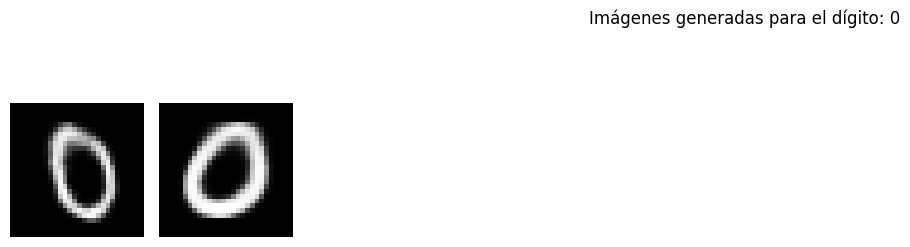

1: Dígito 1


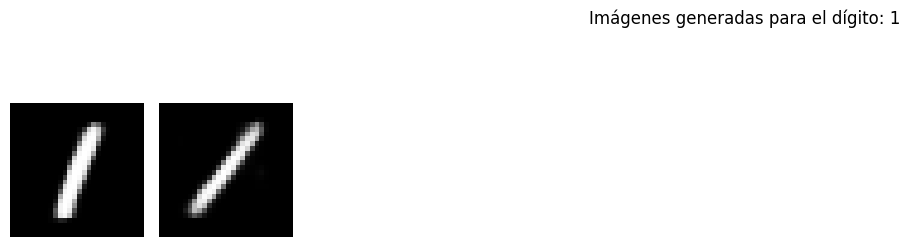

2: Dígito 2


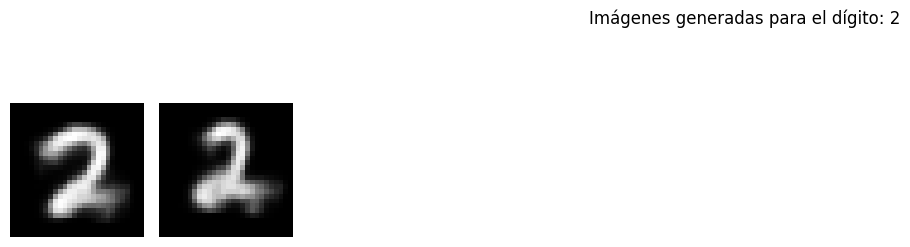

3: Dígito 3


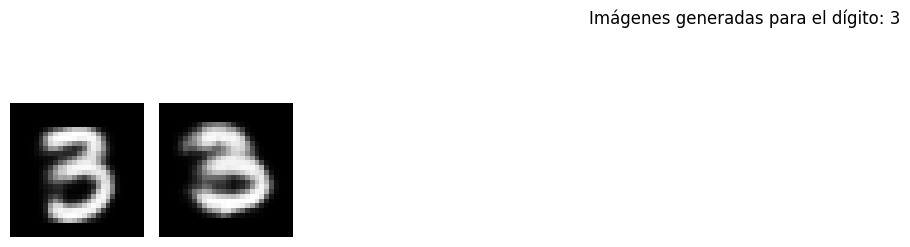

4: Dígito 4


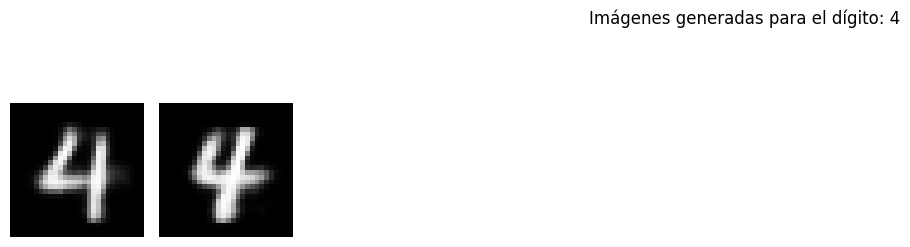

5: Dígito 5


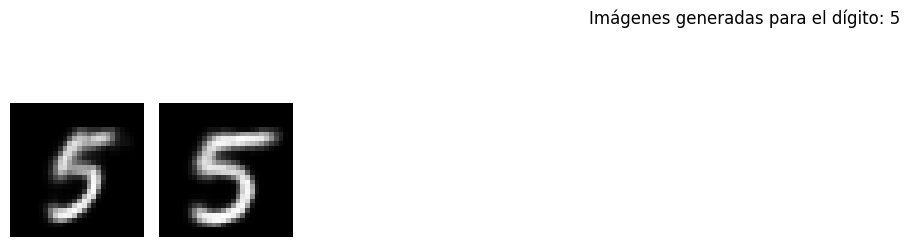

6: Dígito 6


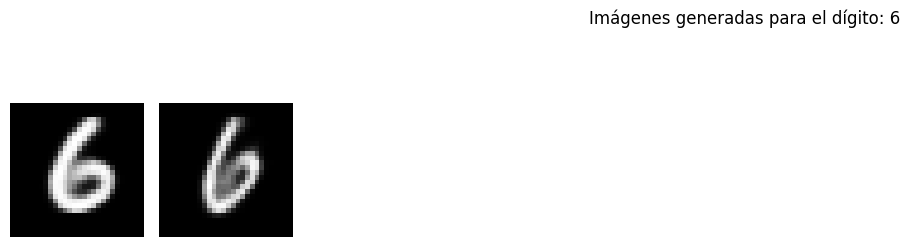

7: Dígito 7


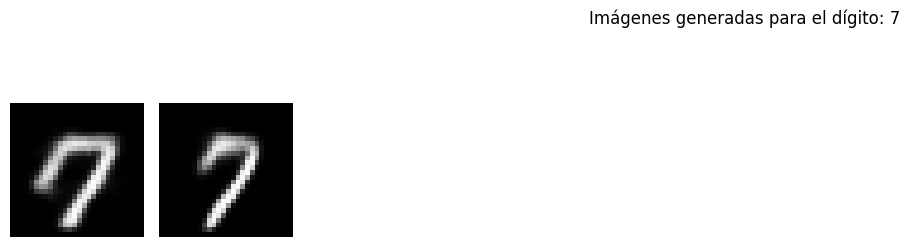

8: Dígito 8


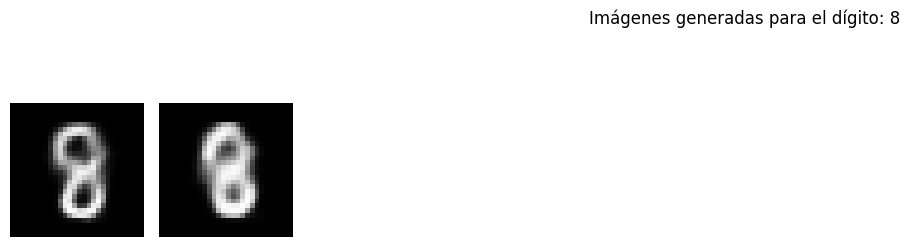

9: Dígito 9


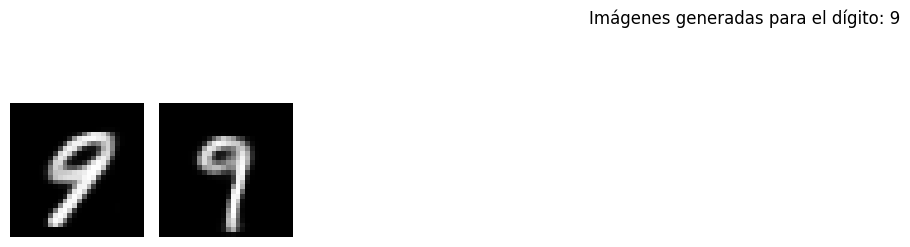

In [106]:
#region
# Función para generar imágenes condicionadas a un dígito específico
def generate_for_digit(model, digit, num_samples=7, device="cuda"):
    """
    Genera num_samples imágenes usando el decoder del modelo,
    condicionadas a la etiqueta proporcionada por 'digit'.
    """
    model.to(device)   # Mover el modelo al dispositivo especificado
    model.eval()  # Modo evaluación
    with torch.no_grad():
        # Crear un tensor de etiquetas one-hot para el dígito indicado
        y = torch.zeros(num_samples, model.hparams.label_dim, device=device)
        y[:, digit] = 1.0
        # Generar vectores latentes aleatorios
        z = torch.randn(num_samples, model.hparams.latent_dim, device=device)
        # Usar el decoder para generar imágenes
        generated = model.decoder(z, y)
    return generated.cpu()

# Función interactiva para pedir al usuario un dígito y generar imágenes
for i in range(10):
    print(f"{i}: Dígito {i}")
    digit_str = i
    try:
        digit = int(digit_str)
        if digit < 0 or digit > 9:
            raise ValueError
    except ValueError:
        print("Por favor, introduce un dígito válido entre 0 y 9.")
        digit = None

    if digit is not None:
        # Generar 10 imágenes para el dígito indicado
        images = generate_for_digit(model_cnn, digit, num_samples=10, device="cuda")
        
        # Visualización: mostramos las 10 imágenes en una fila
        plt.figure(figsize=(15, 3))
        for i in range(2):
            plt.subplot(1, 10, i + 1)
            plt.imshow(images[i].squeeze(), cmap="gray")
            plt.axis("off")
        plt.suptitle(f"Imágenes generadas para el dígito: {digit}")
        plt.tight_layout()
        plt.show()
#endregion